# Monitoring Changes in Surface Water Using Satellite Image Data 

## Python environnement setup, data acquisition, reading 
## and image manipulation with Keras / TensorFlow

<table style="font-size: 1em; padding: 0; margin: 0;">
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">Deliverable</strong>  
    <br/>The deliverable for Part 1 is a jupyter notebook showing an example image(s) of a satellite dataset read in using rasterio, and demonstration of a function that carries out a manipulation of that image using keras and Tensorflow 2.0. That manipulation could be anything that alters the image, such as its size, geometry (shape), pixel intensities, or spatial projection. This will mostly test your understanding of keras syntax, which is an essential component of the remaining Parts. You may find the <a href="https://www.tensorflow.org/api_docs/python/tf/image">ten

### Python packages importation

In [1]:
import os

from matplotlib import pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import rasterio
print("rasterio version",rasterio.__version__)
import tensorflow as tf
print("TensorFlow version",tf.__version__)


rasterio version 0.36.0
TensorFlow version 2.0.0


### Data acquisition

The below function download a sample Sentinel-2 JP2 (JPEG2000) file from google drive

In [2]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

print("Code loaded")

Code loaded


In [3]:
file_id = '1o76QoBtn6ExxO8KgcCqdOiun_KsWoMJl'
destination = 'Lake_Poopo_Bolivia.jp2'
download_file_from_google_drive(file_id, destination)

print("Data downloaded")

Data downloaded


In [4]:
images = rasterio.open('Lake_Poopo_Bolivia.jp2', driver='JP2OpenJPEG')
array = images.read(1)
print(images.profile)


{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS({'init': 'epsg:32719'}), 'transform': (600000.0, 10.0, 0.0, 8000020.0, 0.0, -10.0), 'affine': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 8000020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


### Image file format conversion 

<strong>Tensorflow has no Decoder for TIFF Images!!!</strong>
https://stackoverflow.com/questions/41985509/tensorflow-machine-learning-no-decoder-for-tiff-images

So this is probably the main challenge of that first assessment.

To solve the problem, we will convert the JP2 image to JPG using rasterio (and GDAL underneath)

The following function takes a JP2 image, an output file name (with extension) and a single band number (1, 2, or 3) and writes the raster to a new file.

In [5]:
# C.COULOMBE - I've generalized the function in order to process different format
# So it processes .TIF but also .JPG - insofar the driver arguments remain the same
def write_image(input_file, input_driver, output_file, output_driver, band):
    with rasterio.open(input_file) as src_dataset:
        with rasterio.open(input_file, driver=input_driver) as dataset:
            array = dataset.read(band)
        # Get a copy of the source dataset's profile. Thus our
        # destination dataset will have the same dimensions,
        # number of bands, data type, and georeferencing as the
        # source dataset.
        kwds = src_dataset.profile

        # Change the format driver for the destination dataset to
        # 'GTiff', short for GeoTIFF.
        kwds['driver'] = output_driver

        # Add driver-specific keyword arguments.
        kwds['tiled'] = True
        kwds['blockxsize'] = 256
        kwds['blockysize'] = 256
        kwds['photometric'] = 'YCbCr'
        kwds['compress'] = 'JPEG'

        with rasterio.open(output_file, 'w', **kwds) as dst_dataset:
            # Write data to the destination dataset.
            dst_dataset.write(array.astype(rasterio.uint8), 1)
        return output_file
    
print("Code loaded")

Code loaded


In [6]:
input_file = 'Lake_Poopo_Bolivia.jp2'
input_driver = 'JP2OpenJPEG'
output_driver = 'JPEG'

files_list = [write_image(input_file, input_driver, output_file, output_driver, band) 
 for output_file,band in zip(['r1.jpg', 'r2.jpg', 'r3.jpg'],[1,2,3])]
files_list

/home/user/anaconda3/envs/liveproject/lib/python3.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


['r1.jpg', 'r2.jpg', 'r3.jpg']

This next bit of code gets the meta data from the first file (that is the same as the remaining two files), and writes a merged 3-band raster in JPEG format

In [7]:
# Read metadata of first file
with rasterio.open(files_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(files_list))

# Read each layer and write it to stack
with rasterio.open('Lake_Poopo_Bolivia.jpg', 'w', **meta) as dst:
    for id, layer in enumerate(files_list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

print("Code executed")

Code executed


In [8]:
image_jpg = rasterio.open('Lake_Poopo_Bolivia.jpg', driver='JPEG')

# Get the dimension of the image
print(image_jpg.bounds)

# Get the coordinate reference system used in the image.
print(image_jpg.crs)

# Get the number of bands in the image
print(image_jpg.indexes)


BoundingBox(left=600000.0, bottom=7890220.0, right=709800.0, top=8000020.0)
CRS({'init': 'epsg:32719'})
(1, 2, 3)


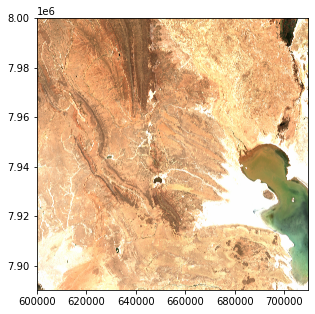

image_jpg.shape: (10980, 10980)


In [9]:
# Show the entire image with 3 bands
from rasterio.plot import show
fig = plt.figure(figsize=(5,5))
show(image_jpg)
print("image_jpg.shape:",image_jpg.shape)


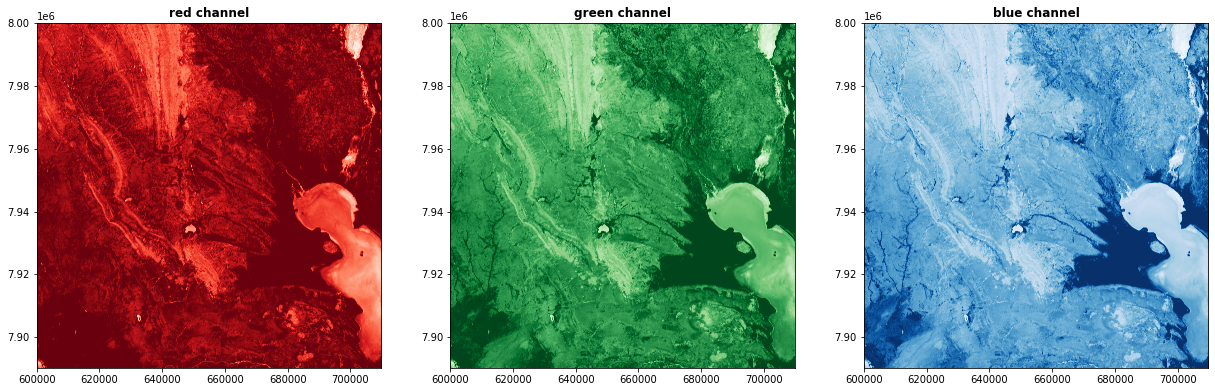

In [10]:
# Showing 3 derived images with each of the 3 bands in the image
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((image_jpg, 1), ax=axr, cmap='Reds', title='red channel')
show((image_jpg, 2), ax=axg, cmap='Greens', title='green channel')
show((image_jpg, 3), ax=axb, cmap='Blues', title='blue channel')
plt.show()


## Image processing with TensorFlow

Now we have a .jpg image we can open and process it using TensorFlow

### Loading image in TensorFlow

(10980, 10980, 3)


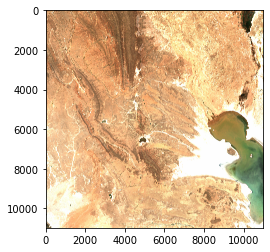

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

file = open("Lake_Poopo_Bolivia.jpg", "rb")
image_jpg = file.read()
file.close()
image_tf = tf.image.decode_jpeg(image_jpg, channels=3)
print(image_tf.shape)
_ = plt.imshow(image_tf)


### Resizing image using TensorFlow

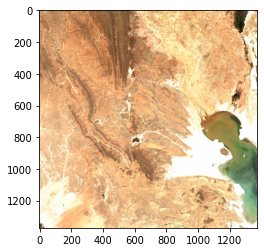

In [2]:
image_tf = tf.image.convert_image_dtype(image_tf, tf.float32)

IMG_HEIGHT = int(image_tf.shape[0]/8)
IMG_WIDTH = int(image_tf.shape[1]/8)

smaller_image_tf = tf.image.resize(image_tf, [IMG_HEIGHT, IMG_WIDTH])

_ = plt.imshow(smaller_image_tf)


### Image rotation using TensorFlow

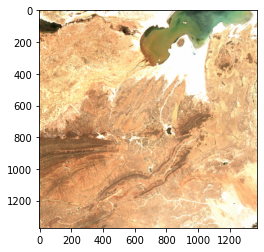

In [3]:
rotated_image_tf = tf.image.rot90(smaller_image_tf)

_ = plt.imshow(rotated_image_tf)


### Image intensity (brightness) using TensorFlow

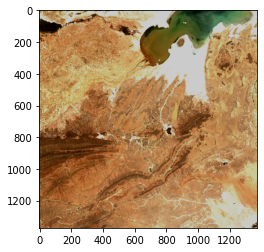

In [4]:
less_bright_image_tf = tf.image.adjust_brightness(rotated_image_tf,delta=-0.2)
_ = plt.imshow(tf.clip_by_value(less_bright_image_tf, clip_value_min=0.0, clip_value_max=1.0))


In [5]:
print("Notebook executed")

Notebook executed
